## Análise de estatísticas econômicas para previsão da inflação
Luigi Monteiro Santos Rangel - 121077746 - 20/12/2023

Neste trabalho, iremos utilizar a relação histórica entre o preço do dólar em relação ao real, a taxa de juros básica do Brasil, o PIB, o preço do petróleo e a inflação no país. A partir de dados de 1995 até novembro de 2023, usaremos SVD e PCA para visualizar o comportamento desses dados para tentar entender as possíveis relações entre eles, e regressão polinomial para gerar uma função que simule o comportamento da inflação. Isto é, dada uma configuração desses indicadores, nossa função irá retornar a expectativa de inflação. Por fim, iremos analisar a acurácia do nosso modelo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

## 1. Obtendo os dados

Para iniciar nossa análise, primeiro precisamos obter os dados. Uma vez que a história de nosso país envolve uma época com índices inflacionários descontrolados, acompanhados por taxas de juros extraordinárias e constantes mudanças cambiais, decidimos utilizar dados mais concisos, que reflitam melhor uma relação atual. Assim, nossa coleta de dados irá começar no ano de 1995, depois da implantação do Plano Real.

Os dados referentes ao Dólar são simplesmente a média do valor de câmbio do dólar comercial no mês em questão. Os valores de taxa de juros refletem o valor da taxa SELIC anual no mês. Quanto aos dados do PIB, foi necessário um ajuste nos dados: os dados mais antigos constavam o valor do PIB no ano, e os valores mais recentes o PIB no trimestre. Para ajustar ao mês, mensalizamos os valores do PIB de forma que o PIB no ano seja o acúmulo dos juros compostos dos 12 meses. Além disso, embora não seja um indicador da economia brasileira, incluimos o valor em dólares do barril de petróleo para verificar de que formas mudanças no valor da commodity impactam na inflação brasileira. Por fim, os valores da inflação foram obtidos da tabela do INPC, Índice Nacional de Preços ao Consumidor, um indicador da inflação nacional obtido mensalmente.

In [2]:
# Carrega os dados
df = pd.read_csv('Gov_Data.csv')

# Transforma os meses em índice
df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index('Month')
df['Taxa de Juros'] = pd.to_numeric(df['Taxa de Juros'])

# Exibe dados
df.head()

,Dolar,Taxa de Juros,PIB,Petroleo,INPC
Month,,,,,
1995-01-01,0.845136,48.84,0.00345,16.5350,1.44
1995-02-01,0.838750,46.78,0.00345,17.1875,1.01
1995-03-01,0.887413,64.97,0.00345,16.9160,1.62
1995-04-01,0.905529,64.97,0.00345,18.4250,2.49
1995-05-01,0.895364,64.78,0.00345,18.3175,2.10


## 2. Visualizando os dados

### 2.1 Histogramas e correlação

Para entendermos a distribuição dos dados de forma independente, podemos 

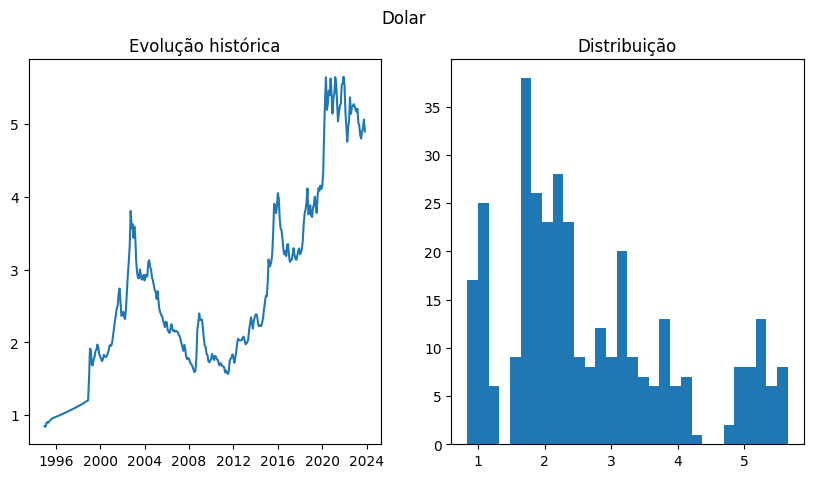

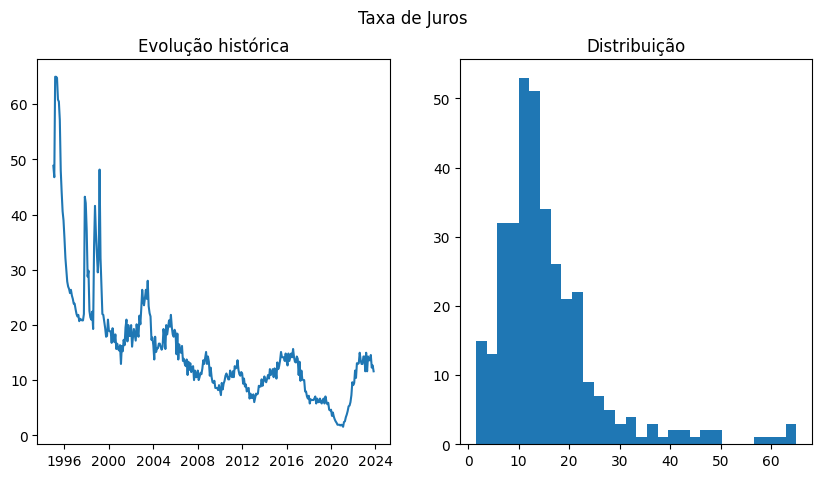

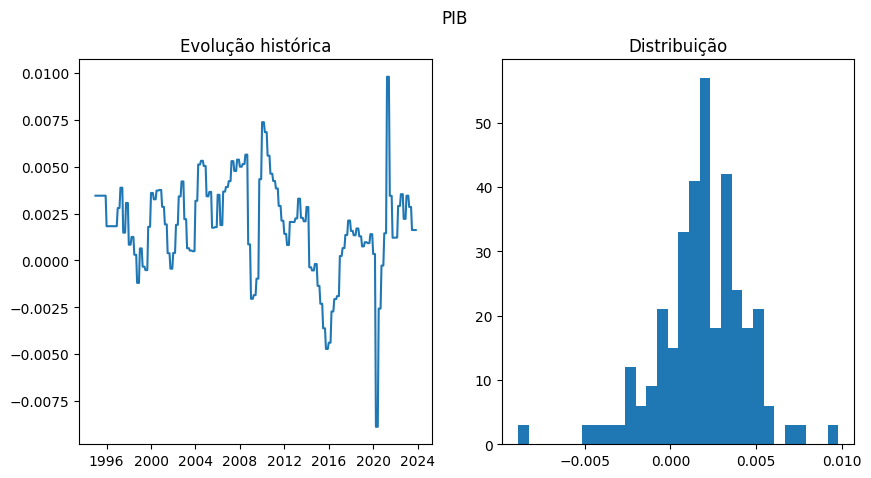

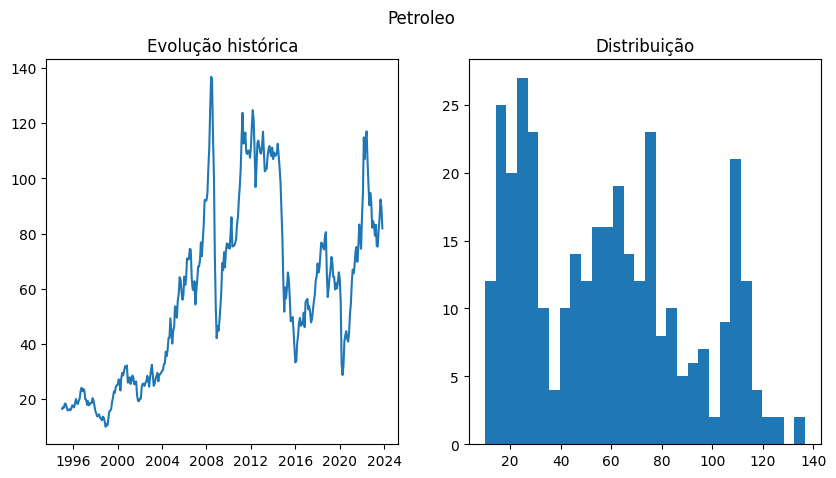

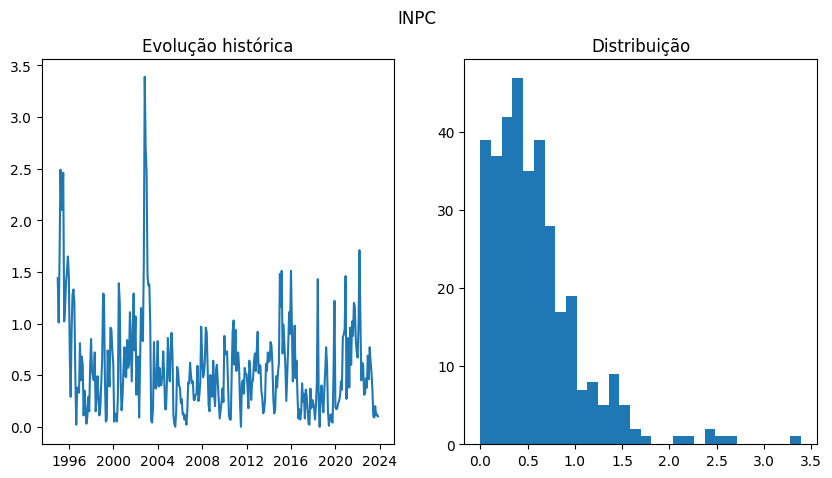

In [3]:
for ind in df.columns:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f'{ind}')

    # Plota evolução dos dados
    axs[0].plot(df[ind])
    axs[0].set_title("Evolução histórica")

    # Exibe histograma dos dados
    axs[1].hist(df[ind], bins=30)
    axs[1].set_title("Distribuição")
    plt.show()

Podemos observar que, embora a distribuição do preço do barril de petróleo e a do dolar sejam as menos coesas, a evolução histórica da inflação é a que apresenta maiores variações mês a mês, com um intervalo de variação menor ou maior dependendo do período. Além disso, podemos verificar, visualmente, que há uma certa tendência de a taxa de juros estar alta junto com os períodos em que a inflação está alta -- o que é verídico, visto que uma estratégia para redução da inflação é o aumento da taxa de juros. Também há uma relação de crescimento conjunto do valor do barril de petróleo com o valor do dólar. Podemos obter uma matriz de correlação pelo método `corr()` do pandas, a fim de atestarmos numericamente as tendências que estamos observando.

In [4]:
df.corr()

,Dolar,Taxa de Juros,PIB,Petroleo,INPC
Dolar,1.000000,-0.521793,-0.250448,0.206777,-0.016436
Taxa de Juros,-0.521793,1.000000,0.069810,-0.586947,0.403870
PIB,-0.250448,0.069810,1.000000,0.221600,0.065336
Petroleo,0.206777,-0.586947,0.221600,1.000000,-0.201721
INPC,-0.016436,0.403870,0.065336,-0.201721,1.000000


Como percebido, há tendência de aumento do INPC e da Taxa de Juros em conjunto, assim como do Petróleo e do Dólar. Entretanto, vemos uma correlação negativa ainda mais forte entre a taxa de juros e o valor do barril de petróleo. Isso pode ser explicado pela ocorrência de valores altos da taxa de juros no fim do século passado, que diminuiram com o crescente controle da inflação, em contraste ao barril de petróleo, que se valorizou com o passar do tempo. Agora, podemos entender a distribuição dos dados em conjunto e a relação entre eles e a inflação.

### 2.2 Visualização por redução de dimensão

Abaixo, utilizaremos o SVD -- decomposição em valores singulares -- para reduzir a dimensão dos dados e conseguimos visualizá-los com algum grau de efetividade. Uma vez que temos um conjunto de 5 variáveis, é impraticável gerar apenas um gráfico que demonstre na prática o comportamento conjunto de cada uma das variáveis. Por isso, ao aplicar um algoritmo de redução de dimensão, podemos obter um subespaço de menor dimensão que nos permita visualizar e entender melhor a relação entre todos os dados. Importante ressaltar que para reduzir a dimensão dos dados há a perda de informação, uma vez que dados em diferentes dimensões são colapsados em subespaços de dimensões menores. Assim, na redução de dimensão, há uma troca de precisão por facilidade de compreensão. Vejamos:

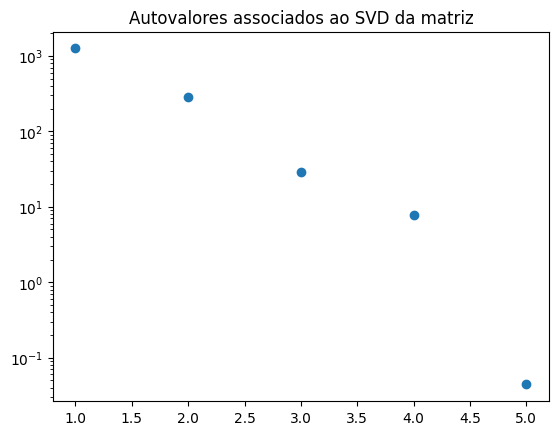

In [5]:
# Cria matriz numpy com os dados
data = np.array(df)

# Função que calcula SVD truncado
def SVD_cut(M, r):
    U, S, V = np.linalg.svd(M)

    U_r, S_r, V_r = U[:,:r], S[:r], V[:r,:]

    return U_r @ np.diag(S_r) @ V_r, U, S, V

# Exemplo
data_reconstructed, U, S, V = SVD_cut(data, 2)

# Representa os autovalores do SVD graficamente
plt.title("Autovalores associados ao SVD da matriz")
plt.yscale('log')
plt.scatter([i for i in range(1, len(S) + 1)], S)
plt.show()

Acima, vemos que os autovalores dos autovetores na decomposição descrescem exponencialmente até o quarto autovalor, enquanto o quinto autovalor é duas ordens de grandeza menor que o quarto. Percebemos, assim, que a redução com quatro dimensões terá pouca perda de informação. Conforme há a redução na dimensão, teremos a compactação dos dados de forma que seja mais fácil de entender os padrões entre os dados.

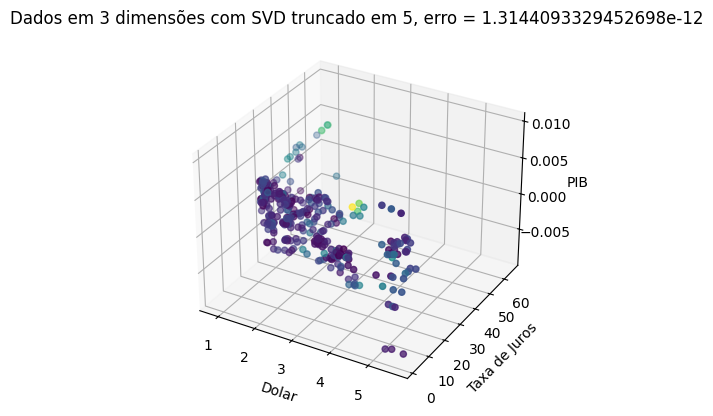

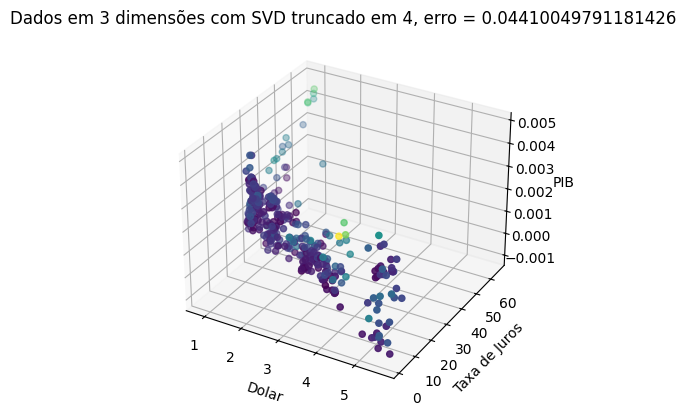

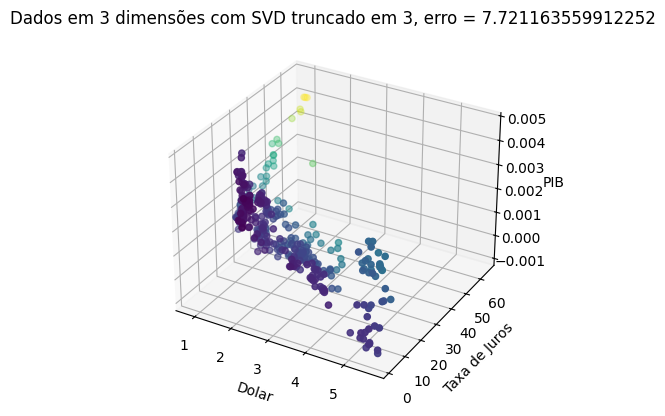

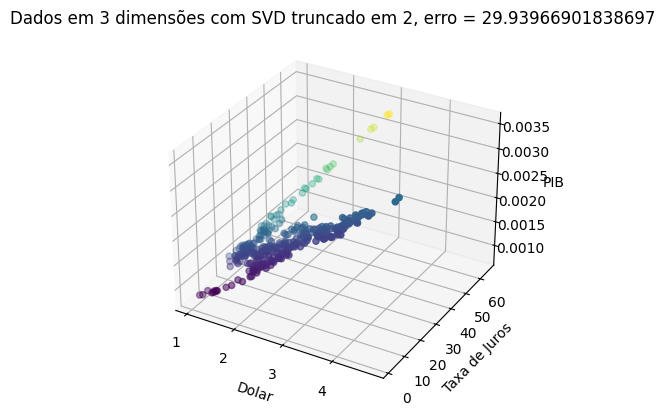

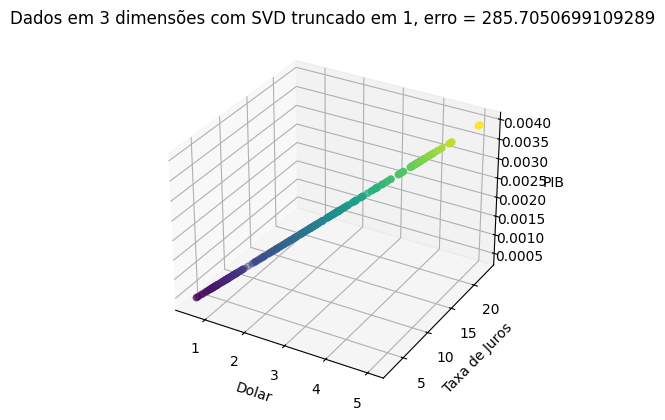

In [6]:
# Representa os pontos da matriz com dimensão cada vez mais reduzida.
for i in range(5, 0, -1):
    ax = plt.subplot(projection="3d")
    data_reconstructed, U, S, V = SVD_cut(data, i)
    ax.scatter(data_reconstructed[:,0], data_reconstructed[:,1], data_reconstructed[:,2], c=data_reconstructed[:,4])
    ax.set_title(f"Dados em 3 dimensões com SVD truncado em {i}, erro = {np.linalg.norm(data - data_reconstructed)}")
    ax.set_xlabel("Dolar")
    ax.set_ylabel("Taxa de Juros")
    ax.set_zlabel("PIB")
    plt.show()

Com os gráficos gerados acima, conseguimos entender não apenas o formato e a relação dos dados mas também podemos compreender e tentar entender as causas das possíveis correlações entre as variáveis. A análise acima, feita apenas para três eixos, poderia ter sido feita para quaisquer três eixos dos quatro (sem a inflação), mas o foco será em demonstrar a mudança na disposição dos dados para que encaixem em subespaços de n dimensões, e a quais conclusões esses encaixes podem nos levar.

Acima, podemos observar que embora com 4 e 5 dimensões o erro seja pequeno, como só conseguimos plotar 3 das dimensões, não conseguimos enxergar as informações e as tendências principais que regem o comportamento de todas as variáveis. Já com 3 dimensões, temos nossos dados em um subespaço que finalmente podemos enxergar. Isso pode ser visto uma vez que, na terceira imagem, as cores (que exibem a inflação naquele ponto) crescem em uma mesma direção. Ou seja, já conseguimos entender que, com a taxa de juros e o PIB altos e o dolar baixo, tendemos a ter índices inflacionários mais altos. Isso está de acordo com o que vimos na correlação. Além disso, conseguimos enxergar em que parte do espaço os pontos se concentram, em 3 dimensões já conseguimos ver um formato aproximado que os dados seguem e dentro desse subespaço a direção de crescimento da inflação. 

Com apenas duas dimensões, o erro aumenta mais, mas conseguimos gerar um plano no espaço que rege o comportamento da função. Observando o comportamento desse plano, podemos perceber uma tendência do Dolar estar menor, a taxa de juros estar média e o PIB estar baixo quando a inflação está baixa. Fora dessa concentração, existe um caminho em que o juros está muito alto, o dólar está mediano e o PIB está mais alto, que resulta em inflações muito altas, e quase como se completasse uma parábola no plano há um outro caminho com a taxa de juros mais baixa, mas o PIB alto e o dólar mais alto, com índices inflacionários mais baixos. Mais à frente, utilizaremos PCA para enxergar melhor o formato dos dados nesse plano. Entretanto, com o SVD ainda conseguimos enxergar o significado dos autovetores gerados e da disposição dos dados em relação a esses autovetores. Podemos ver aqui que, dependendo da taxa de juros, valores maiores de dólar e do PIB podem significar coisas diferentes para a inflação.

Por fim, com uma dimensão apenas e um erro muito alto, podemos apenas ver o maior autovetor associado ao conjunto de dados. Perdemos muita informação, mas ganhamos visualização a nível máximo: quanto maior o dólar, a taxa de juros e o PIB, há uma tendência de a inflação ser maior. Se analisarmos a matriz de correlação, vemos que o PIB e a taxa de juros realmente têm uma correlação positiva com a inflação. Por outro lado, o maior autovetor demonstra uma tendência que a matriz de correlação mostrou inversa, uma vez que o espaço gerado apenas pelo maior autovetor mostra uma relação claramente positiva entre o valor do dólar e a inflação, enquanto a matriz indica uma correlação de -0.01. É importante notar que a maior tendência na economia brasileira realmente demonstra aumentos nos preços quando o dólar sobe, dado o aumento nos preços dos produtos importados.

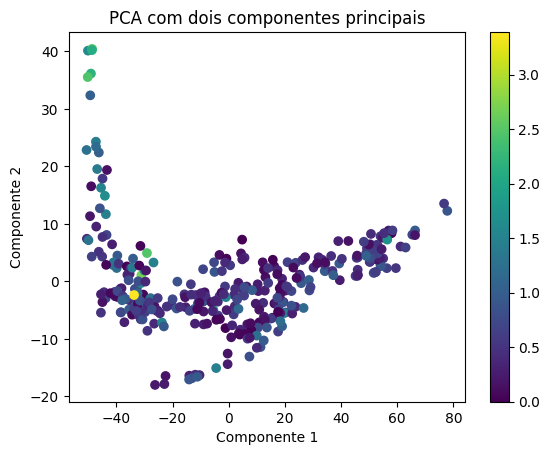

In [7]:
pca = PCA(n_components=2)

x = np.delete(data, [4], 1)

data_pca = pca.fit_transform(x)

plt.scatter(data_pca[:,0], data_pca[:,1], c=data[:,4])
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.title("PCA com dois componentes principais")
plt.colorbar()
plt.show()

O PCA, ou Análise de Componentes Principais, é o método de redução de dimensão que utiliza da covariância entre as variáveis para entender como os dados se comportam em relação aos comportamentos mais presentes na matriz. Os vetores encontrados pelo PCA não têm nenhum significado direto, como os autovetores do SVD, mas são importantes para podermos trazer os dados em menor dimensão para suas dimensões iniciais. A saída do PCA, no caso acima, com duas componentes, são a relação dos dados a essas componentes. Como podemos ver, em duas dimensões, as componentes se assemelham bastante ao plano gerado pelo SVD truncado em duas dimensões, com uma aglomeração central e dois caminhos em uma curva quase parabólica: um com menor inflação, outro com maior inflação. Podemos ver que há uma semelhança muito grande entre o plano gerado pelo PCA e o gerado pelo SVD, embora a relação da inflação esteja tão visível no PCA. A visualização pelo PCA pode ser utilizada para entender a disposição de dados em dimensões maiores e a relação entre eles, assim como o SVD. Neste caso, sua análise foi interessante para trazer a visualização do plano com os dados com maior praticidade.

## 3. Regressão Polinomial

Abaixo, utilizaremos da regressão polinomial para, a partir dos dados de taxa de juros, pib, valor do dólar e barril de petróleo, retornar a expectativa de inflação em um mês com esses valores. A regressão polinomial gera coeficientes para um polinômio de grau $g$ que representa a função dada. Por exemplo, se $g = 2$ e temos uma função de duas variáveis, a regressão retorna $c_0$, $c_1$, $c_2$, $c_3$, $c_4$ e $c_5$ para os quais 

$$f(x_1, x_2) \approx c_0 + c_1 \cdot x_1 + c_2 \cdot x_2 + c_3 \cdot x_1^2 + c_4 \cdot x_1 x_2 + c_5 \cdot x_2^2$$

em que f é a função que queremos aproximar.

Dadas $n$ variáveis, temos $\frac{(n + g - 1)!}{g!(n - 1)!}$ monômios de grau $g$ possíveis. Para todos os graus até $4$, com nossas 4 variáveis, por exemplo, $1 + 4 + 10 + 20 + 35 = 70$ coeficientes precisam ser gerados. Assim, para cada linha, são calculados os valores das variáveis associadas aos coeficientes que, quando multiplicados, gerarão o valor da função -- no caso, da inflação. Ou seja, calculamos a matriz de Vandermonde, mas estendida para funções multivariáveis.

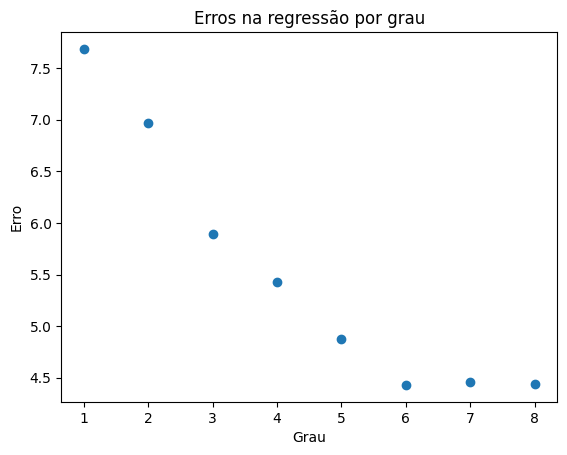

In [8]:
# Gera a matriz multivariável
def calc_inputs(vars, degree):
    x = []
    for degree in range(degree + 1):
        for deg_x4 in range(degree + 1):
            for deg_x3 in range(degree - deg_x4 + 1):
                for deg_x2 in range(degree - deg_x4 - deg_x3 + 1):
                    deg_x1 = degree - deg_x4 - deg_x3 - deg_x2
                    x.append((vars[:,0] ** deg_x1) * (vars[:,1] ** deg_x2) * (vars[:,2] ** deg_x3) * (vars[:,3] ** deg_x4))
    
    return np.array(x).T

errors = []

vars = pd.DataFrame()
returns = pd.DataFrame()

# Define as 4 variáveis
vars['x1'] = data[:,0]
vars['x2'] = data[:,1]
vars['x3'] = data[:,2]
vars['x4'] = data[:,3]

# Define a variável de retorno da função
returns['z'] = data[:,4]

for deg in range(1, 9):
    # Calcula matriz para cada grau
    A = calc_inputs(np.array(vars), deg)
    b = np.array(returns)

    # Calcula coeficientes via mínimos quadrados
    coeffs, resids, rank, s = np.linalg.lstsq(A, b, rcond=None)

    # Calcula o erro do modelo nos dados utilizados
    errors.append(np.linalg.norm(A @ coeffs - b))

# Representando graficamente os erros por grau da função
plt.title("Erros na regressão por grau")
plt.scatter([i for i in range(1, 9)], errors)
plt.xlabel("Grau")
plt.ylabel("Erro")
plt.show()

Como podemos ver acima, o erro na regressão diminuiu até chegar próximo a $4.5$, com grau $6$, quando se estabilizou. Como cada grau aumenta substancialmente o nível de ajuste do modelo aos dados específicos, isto é, como cada aumento de grau gera a necessidade de muito mais linhas no modelo, para evitar o sobreajuste, podemos escolher grau 6 para nosso modelo.

In [69]:
deg = 6

A = calc_inputs(np.array(vars), deg)
b = np.array(returns)

coeffs, resids, rank, s = np.linalg.lstsq(A, b, rcond=None)

# Calcula a previsão a partir do modelo
def predict_inpc(vars, deg):
    predict_inputs = calc_inputs(np.array(vars), deg)
    predict_res = (predict_inputs @ coeffs)
    return predict_res

# Variáveis de teste baseado nas previsões do infomoney
test_vars = [[5,9.25,0.002401,81]]
test_results = 0.321744 # Inflação prevista pelo infomoney para 2024 mensalizada

# Previsão mensalizada para 2024
predict_results = predict_inpc(test_vars, deg)[0][0]

print(f'O valor previsto para a inflação foi de {predict_results}')
print(f'O erro na previsão em relação à fonte foi de {np.round(100 * abs(predict_results / test_results - 1), 2)}%')

O valor previsto para a inflação foi de 0.4790521035197344
O erro na previsão em relação à fonte foi de 48.89%


## 4. Análise e Conclusão

Como podemos ver, o erro foi considerável. Isso ocorre pois a relação polinomial é um modelo que representa os dados de forma quase interpolada, isto é, gera um modelo com alto sobreajuste. Se, por exemplo, um ponto gerado é entendido como mínimo local pelo modelo, os pontos adjacentes terão previsões muito maiores do que provavelmente ocorreria. Desta forma, apesar de ter um erro menor para os dados de teste, a regressão polinomial se mostrou uma escolha inflexível para o nosso problema. 

In [79]:
# Mais variáveis de teste para entender o entorno
test_vars = [
    [5,11,0.002401,81], # Aumentando o valor da taxa de juros
    [4.9,9.25,0.002401,81], # Diminuindo o valor do dolar
    [5.1,9.25,0.002401,81], # Aumentando o valor do dolar
    [5,9.25,0.002401,75], # Diminuindo o valor do petroleo
    [5,9.25,0.002401,87], # Aumentando o valor do petroleo
]

predict_inpc(test_vars, deg)

array([[0.32354779],
       [0.35488461],
       [0.62476835],
       [0.47626112],
       [0.59263337]])

Ainda assim, vale ressaltar que o modelo gerou, ao menos nas adjacências da previsão do infomoney, valores condizentes com o comportamento da inflação: ao aumentar o valor da taxa de juros, o modelo espera que a inflação esteja mais controlada. Ao aumentar ou diminuir o valor do dólar, a inflação segue de acordo, assim como descrito anteriormente. Entretanto, ao contrário dos últimos exemplos, que o aumento ou diminuição no valor gerado da inflação foi substancial, as mudanças no valor do petróleo não geraram impacto tão grande no valor da inflação. 

Em suma, exercitamos a visualização de dados, a redução de dimensão e o uso de regressão polinomial. Nosso modelo gera valores próximos a valores inflacionários, e simula com algum grau de corretude as dinâmicas nas proximidades dos valores gerados. Não obstante, os valores gerados não são condizentes o bastante com a realidade para que seja um modelo confiável.

Possibilidades de melhoria no modelo poderiam envolver incluir a variável temporal na análise, de forma a ter uma relação direta entre as tendências da época e o valor da inflação, uma melhor padronização dos dados, para que aumentos e diminuições em valores como o dolar e o barril de petroleo sejam considerados, em vez do valor em si. Entretanto, considerar as tendências temporais tornariam nosso modelo menos genérico em relação aos indicadores que estávamos analisando, assim como utilizar o dado cambial e o da commodity com percentuais iria dificultar a precisão de análises que distoassem da realidade atual. Embora não tenha sido o foco deste trabalho, o uso de um modelo mais apropriado de regressão, possivelmente com o uso de redes neurais e aprendizado de máquina, provavelmente resultaria em modelos muito mais acurados.

### Fontes
1. https://sidra.ibge.gov.br/Tabela/1736
2. http://www.ipeadata.gov.br/ExibeSerie.aspx?serid=38590&module=M
3. http://www.ipeadata.gov.br/exibeserie.aspx?serid=38402
4. https://infograficos.gazetadopovo.com.br/economia/pib-do-brasil/
5. http://www.ipeadata.gov.br/exibeserie.aspx?serid=38414
6. https://www.bloomberg.com/quote/CO1:COM
7. https://www.infomoney.com.br/economia/boletim-focus-projecao-de-inflacao-para-2023-recua-de-novo-estimativas-de-pib-se-mantem/
8. https://edition.cnn.com/2023/12/18/business/oil-price-forecast-goldman-sachs/index.html#:~:text=The%20Wall%20Street%20bank%20wrote,%2485%20a%20barrel%20next%20June.
9. https://niharjamdar.medium.com/2-d-visualization-using-principal-component-analysis-pca-on-mnist-dataset-e833ee212cc9
10. https://brasilescola.uol.com.br/historia/inflacao-no-brasil.htm#:~:text=Os%20%C3%ADndices%20inflacion%C3%A1rios%20brasileiros%20come%C3%A7aram,95%25%20no%20m%C3%AAs%20de%20dezembro.